# Projet Fraude 



In [211]:
import warnings
warnings.simplefilter('ignore')
#autres
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix

### Importer les dataset

In [2]:
fraud=pd.read_csv('Fraud_Data.csv')
ip=pd.read_csv('IpAddress_to_Country.csv')
fraud.shape, ip.shape

((151112, 11), (138846, 3))

In [3]:
#target --> class : 1 Fraud | 0 ok 
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


### Créer une nouvelle colonne `country` en effectuant une jointure entre les deux dataset 

In [5]:
print(np.min(fraud.ip_address), np.max(fraud.ip_address) , 
      np.min(ip.lower_bound_ip_address), np.max(ip.upper_bound_ip_address))
#On voit ici que certaines ip de fraud sont au dessus ou au dessous des intervalles de ip

52093.4968949854 4294850499.67884 16777216.0 3758096383


In [7]:
fraud=fraud[ (fraud['ip_address'] > ip['lower_bound_ip_address'].min())
           & (fraud['ip_address'] < ip['upper_bound_ip_address'].max()) ]
fraud.shape

(131095, 11)

In [8]:
#On merge ip. dans fraud
fraud=pd.merge_asof(fraud.sort_values('ip_address'), ip, left_on='ip_address', 
                  right_on='lower_bound_ip_address', direction='forward')
fraud=fraud.drop(columns='lower_bound_ip_address')
fraud=fraud.drop(columns='upper_bound_ip_address')


In [9]:
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,247547,2015-06-28 03:00:34,2015-08-09 03:57:29,47,KIXYSVCHIPQBR,SEO,Safari,F,30,1.677886e+07,0,China
1,220737,2015-01-28 14:21:11,2015-02-11 20:28:28,15,PKYOWQKWGJNJI,SEO,Chrome,F,34,1.684205e+07,0,China
2,390400,2015-03-19 20:49:09,2015-04-11 23:41:23,44,LVCSXLISZHVUO,Ads,IE,M,29,1.684366e+07,0,China
3,69592,2015-02-24 06:11:57,2015-05-23 16:40:14,55,UHAUHNXXUADJE,Direct,Chrome,F,30,1.693873e+07,0,Thailand
4,174987,2015-07-07 12:58:11,2015-11-03 04:04:30,51,XPGPMOHIDRMGE,SEO,Chrome,F,37,1.697198e+07,0,China


In [10]:
#On a des données ordonnées différemment de l'exemple

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


### Créer une nouvelle variable `time_diff` qui sera la différence entre les variables `purchase_time` et `signup_time`

In [11]:
from datetime import datetime


In [37]:
# t1=Datetime(100)
compt=0
for i in range(len(fraud)) :
    t1=datetime.strptime(fraud.loc[i,'signup_time'], "%Y-%m-%d %H:%M:%S")
    t2=datetime.strptime(fraud.loc[i,'purchase_time'], "%Y-%m-%d %H:%M:%S")
    fraud.loc[i, 'time_diff']=(t2-t1).total_seconds()


In [39]:
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff
0,247547,2015-06-28 03:00:34,2015-08-09 03:57:29,47,KIXYSVCHIPQBR,SEO,Safari,F,30,1.677886e+07,0,China,3632215.0
1,220737,2015-01-28 14:21:11,2015-02-11 20:28:28,15,PKYOWQKWGJNJI,SEO,Chrome,F,34,1.684205e+07,0,China,1231637.0
2,390400,2015-03-19 20:49:09,2015-04-11 23:41:23,44,LVCSXLISZHVUO,Ads,IE,M,29,1.684366e+07,0,China,1997534.0
3,69592,2015-02-24 06:11:57,2015-05-23 16:40:14,55,UHAUHNXXUADJE,Direct,Chrome,F,30,1.693873e+07,0,Thailand,7640897.0
4,174987,2015-07-07 12:58:11,2015-11-03 04:04:30,51,XPGPMOHIDRMGE,SEO,Chrome,F,37,1.697198e+07,0,China,10249579.0


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461


### Regroupper les `user_id` par `device_id`  afin d'avoir le nombre de device par client  

In [56]:
fraud['device_num']=fraud.groupby('device_id').user_id.transform(len)


In [57]:
fraud.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num
0,247547,2015-06-28 03:00:34,2015-08-09 03:57:29,47,KIXYSVCHIPQBR,SEO,Safari,F,30,1.677886e+07,0,China,3632215.0,1
1,220737,2015-01-28 14:21:11,2015-02-11 20:28:28,15,PKYOWQKWGJNJI,SEO,Chrome,F,34,1.684205e+07,0,China,1231637.0,1
2,390400,2015-03-19 20:49:09,2015-04-11 23:41:23,44,LVCSXLISZHVUO,Ads,IE,M,29,1.684366e+07,0,China,1997534.0,2
3,69592,2015-02-24 06:11:57,2015-05-23 16:40:14,55,UHAUHNXXUADJE,Direct,Chrome,F,30,1.693873e+07,0,Thailand,7640897.0,1
4,174987,2015-07-07 12:58:11,2015-11-03 04:04:30,51,XPGPMOHIDRMGE,SEO,Chrome,F,37,1.697198e+07,0,China,10249579.0,1


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1


### Faire de même pour les `ip_address` 

In [58]:
fraud['ip_num']=fraud.groupby('ip_address').user_id.transform(len)


### Traiter les variables `signup_time` & `purchase_time` afin de les différencier suivant la semaine et le week end  

In [96]:
for i in range(len(fraud)) :
    fraud.loc[i,['signup_week','signup_day']]=datetime.strptime( (fraud.loc[i,'signup_time']) , 
                                                                "%Y-%m-%d %H:%M:%S").isocalendar()[1:]

In [102]:
for i in range(len(fraud)) :
    fraud.loc[i,['purchase_week','purchase_day']]=datetime.strptime( (fraud.loc[i,'purchase_time']) , 
                                                                "%Y-%m-%d %H:%M:%S").isocalendar()[1:]

In [121]:
fraud['signup_week']=fraud['signup_week'].astype('int64')
fraud['signup_day']= fraud['signup_day'].astype('int64')
fraud['purchase_week']=fraud['purchase_week'].astype('int64')
fraud['purchase_day']=fraud['purchase_day'].astype('int64')

In [122]:
fraud.head()
#Les purchase et signup day démarrent à 1, mais je le laisse car ce n'est pas important

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num,signup_week,signup_day,purchase_week,purchase_day
0,247547,2015-06-28 03:00:34,2015-08-09 03:57:29,47,KIXYSVCHIPQBR,SEO,Safari,F,30,1.677886e+07,0,China,3632215.0,1,1,26,7,32,7
1,220737,2015-01-28 14:21:11,2015-02-11 20:28:28,15,PKYOWQKWGJNJI,SEO,Chrome,F,34,1.684205e+07,0,China,1231637.0,1,1,5,3,7,3
2,390400,2015-03-19 20:49:09,2015-04-11 23:41:23,44,LVCSXLISZHVUO,Ads,IE,M,29,1.684366e+07,0,China,1997534.0,2,1,12,4,15,6
3,69592,2015-02-24 06:11:57,2015-05-23 16:40:14,55,UHAUHNXXUADJE,Direct,Chrome,F,30,1.693873e+07,0,Thailand,7640897.0,1,1,9,2,21,6
4,174987,2015-07-07 12:58:11,2015-11-03 04:04:30,51,XPGPMOHIDRMGE,SEO,Chrome,F,37,1.697198e+07,0,China,10249579.0,1,1,28,2,45,2


### Définir vos variables de travail (X,y)

In [129]:
feat=['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
        'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num']
targ='class'
X=fraud[feat]
Y=fraud[targ]


In [123]:
fraud[[*feat, targ]].head()



,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
0,7,26,7,32,47,SEO,Safari,F,30,China,3632215.0,1,1,0
1,3,5,3,7,15,SEO,Chrome,F,34,China,1231637.0,1,1,0
2,4,12,6,15,44,Ads,IE,M,29,China,1997534.0,2,1,0
3,2,9,6,21,55,Direct,Chrome,F,30,Thailand,7640897.0,1,1,0
4,2,28,2,45,51,SEO,Chrome,F,37,China,10249579.0,1,1,0


,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,13882,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1,12,12,1
3,1,18,0,19,44,SEO,Safari,M,41,NA,60085,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,41461,1,1,0


### Afficher les informations du dataset afin de vizualiser les variables numeriques et categoriques

In [126]:
fraud[[*feat, targ]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131095 entries, 0 to 131094
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   signup_day      131095 non-null  int64  
 1   signup_week     131095 non-null  int64  
 2   purchase_day    131095 non-null  int64  
 3   purchase_week   131095 non-null  int64  
 4   purchase_value  131095 non-null  int64  
 5   source          131095 non-null  object 
 6   browser         131095 non-null  object 
 7   sex             131095 non-null  object 
 8   age             131095 non-null  int64  
 9   country         131095 non-null  object 
 10  time_diff       131095 non-null  float64
 11  device_num      131095 non-null  int64  
 12  ip_num          131095 non-null  int64  
 13  class           131095 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 19.0+ MB


On notera que j'ai perdu 20 000 points durant la jointure mais que ceux-ci sont toujours là dans les résultats attendus.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151112 entries, 0 to 151111
Data columns (total 14 columns):
signup_day        151112 non-null int64
signup_week       151112 non-null int64
purchase_day      151112 non-null int64
purchase_week     151112 non-null int64
purchase_value    151112 non-null int64
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
country           151112 non-null object
time_diff         151112 non-null int64
device_num        151112 non-null int64
ip_num            151112 non-null int64
class             151112 non-null int64
dtypes: int64(10), object(4)
memory usage: 17.3+ MB


### Traiter les variables catégoriques

In [130]:
src_encode=LabelEncoder()
X['source']=src_encode.fit_transform(X['source'])

brw_encode=LabelEncoder()
X['browser']=brw_encode.fit_transform(X['browser'])

sex_encode=LabelEncoder()
X['sex']=sex_encode.fit_transform(X['sex'])

cnt_encode=LabelEncoder()
X['country']=cnt_encode.fit_transform(X['country'])


### Spliter vos variables 

In [141]:
x_train, x_test, y_train, y_test = train_test_split(X, Y , test_size=0.3)

In [142]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((91766, 13), (91766,), (39329, 13), (39329,))

Shape du dataset d'entrainement : (105778, 13) | Shape du dataset de test : (45334, 13)


### Instancier un `RandomForestClassifier` et l'entrainer sur vos données 

In [143]:
rfc=RandomForestClassifier()
rfc.fit(x_train, y_train)

RandomForestClassifier()

### Afficher l'accuracy moyenne pour 10 'fold cross validation'

In [160]:
fcv=cross_val_score(rfc, x_train, y_train, scoring='accuracy', cv=10)

In [161]:
fcv.mean()

0.9560186001944325

L'accuracy moyenne pour 10 'fold cross validation' est 95.56%


### Afficher les `feature_importances_`

In [172]:
print(rfc.feature_names_in_, rfc.feature_importances_)


['signup_day' 'signup_week' 'purchase_day' 'purchase_week'
 'purchase_value' 'source' 'browser' 'sex' 'age' 'country' 'time_diff'
 'device_num' 'ip_num'] [0.02868245 0.07402619 0.03124344 0.19881649 0.06478622 0.01279771
 0.02197902 0.01053313 0.05723331 0.04108689 0.26860744 0.1007695
 0.0894382 ]


time_diff         0.274568
purchase_week     0.145555
ip_num            0.137471
device_num        0.089743
signup_week       0.084465
purchase_value    0.064497
age               0.054936
country           0.040763
signup_day        0.033725
purchase_day      0.029160
browser           0.021741
source            0.013733
sex               0.009643
dtype: float64

### Vizualiser les sur un graphique 

<AxesSubplot:>

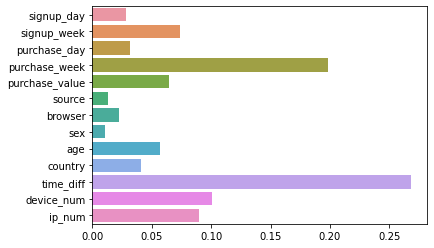

In [175]:
sns.barplot(x=rfc.feature_importances_, y=rfc.feature_names_in_)

Text(0.5, 1.0, 'Visualizing Important Features')

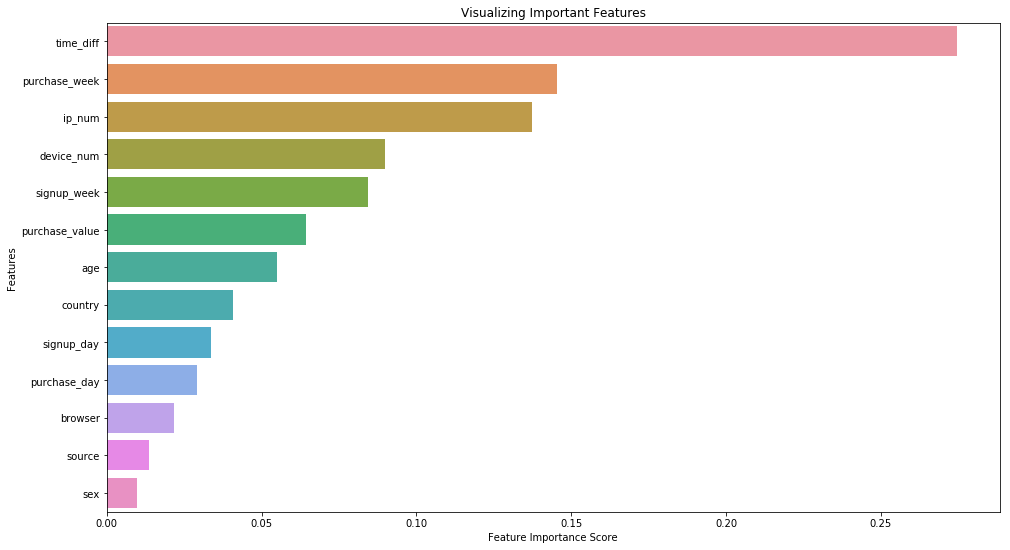

### Afficher le `Classification report`

In [190]:
y_pred=rfc.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     35665
           1       1.00      0.54      0.70      3664

    accuracy                           0.96     39329
   macro avg       0.98      0.77      0.84     39329
weighted avg       0.96      0.96      0.95     39329



              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41177
           1       1.00      0.55      0.71      4157

   micro avg       0.96      0.96      0.96     45334
   macro avg       0.98      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



### Traçer la courbe AUC 

AUC = Area under curve

[0.00000000e+00 1.96270854e-04 1.00000000e+00]
[0.         0.53984716 1.        ]


<AxesSubplot:>

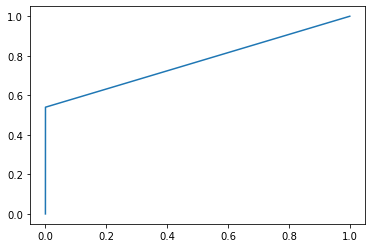

In [201]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# auc(fpr, tpr)
print(fpr)
print(tpr)
sns.lineplot(fpr, tpr)

### Afficher la matrice de confusion 
Qu'en pensez vous ? 

<AxesSubplot:>

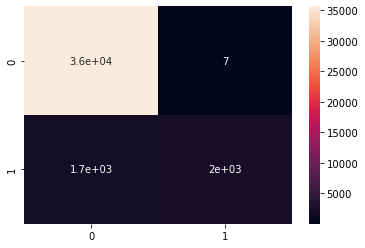

In [206]:
co=confusion_matrix(y_test, y_pred)
sns.heatmap(co, annot = True)

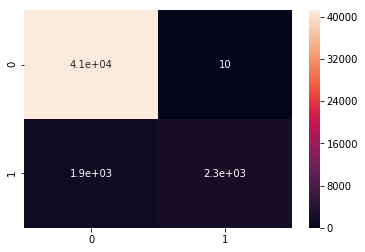

### Faire une selection de certaine variables et spliter vos varibales 

In [207]:
feat_red=['time_diff', 'purchase_week', 'ip_num', 'device_num'] 
X_red=fraud[feat_red]


In [208]:
x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(X_red, Y , test_size=0.3)
x_train_red.shape, y_train_red.shape, x_test_red.shape, y_test_red.shape

((91766, 4), (91766,), (39329, 4), (39329,))

Shape du dataset d'entrainement : (105778, 4) | Shape du dataset de test : (45334, 4)


### Entrainer un classifieur `LogisticRegression` sur ces variables 

In [212]:
lr=LogisticRegressionCV()
lr.fit(x_train_red, y_train_red)

LogisticRegressionCV()

In [213]:
cvs=cross_val_score(lr, x_train_red, y_train_red, scoring='accuracy', cv=10)

In [214]:
cvs.mean()

0.9556044205791382

L'accuracy moyenne pour 10 'fold cross validation' est 95.39%
